<center>
<img src="https://i.ibb.co/b3T5hkz/logo.png" alt="logo" border="0" width=600>


---
## 01. A Classification Neural Network with PyTorch


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Abstract

In this notebook we will implement a classification neural network to represent a linear model using `PyTorch`.

---

## Stellar Types

We will consider a dataset from [Deepraj Baidya](https://www.kaggle.com/deepu1109) available at

[https://www.kaggle.com/datasets/deepu1109/star-dataset](https://www.kaggle.com/datasets/deepu1109/star-dataset)


This is a dataset includes 240 objects (samples) and 7 features of stars

- Absolute Temperature [$K$]
- Relative Luminosity [$L/L_{\odot}$]
- Relative Radius [$R/R_{\odot}$]
- Absolute Magnitude [$M_v$]
- Star Color [white,Red,Blue,Yellow,yellow-orange etc]
- Spectral Class [O,B,A,F,G,K,M]
- **Star Type [Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , SuperGiant, HyperGiant]**

where 

$L_{\odot} = 3.828 x 10^26$ Watts (Avg Luminosity of Sun)

$R_{\odot} = 6.9551 x 10^8$ m (Avg Radius of Sun).

The data is a combination of observational and synthetic values. We want to train a decision tree algorithm that predicts the *Star Type* from the other 6 features in the dataset.

In [1]:
import torch
from torch import nn
import torch.optim as optim

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(413)

## The Dataset


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Neural Networks/02. Classification Networks/6class.csv')
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue,O
236,30839,834042.000000,1194.0000,-10.63,5,Blue,O
237,8829,537493.000000,1423.0000,-10.73,5,White,A
238,9235,404940.000000,1112.0000,-11.23,5,White,A


We will use this data to obtain the Hertzprung-Rusell diagram,

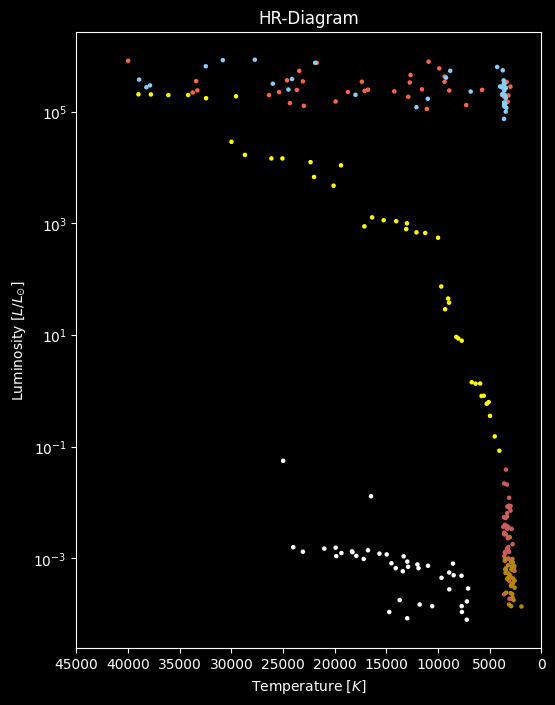

In [3]:
colors = {0:'darkgoldenrod' , 1:'indianred', 2:'white', 3:'yellow', 4:'tomato', 5:'lightskyblue'}

plt.style.use('dark_background')
plt.figure(figsize=(6,8))
plt.scatter(df['Temperature (K)'], df['Luminosity(L/Lo)'], marker='.',
            c = [colors[i] for i in df['Star type']],
            s=20)

plt.xlim(45000,0)
plt.yscale('log')
plt.xlabel(r'Temperature [$K$]')
plt.ylabel(r'Luminosity [$L/L_{\odot}$]')
plt.title('HR-Diagram')
plt.show()

---
## Preparing the Data

We will transform the features 'Temperature (K)' and 'Luminosity(L/Lo)' in the dataframe into a NumPy array.

In [4]:
X = df[['Temperature (K)','Luminosity(L/Lo)']].to_numpy()
X[:10]

array([[3.068e+03, 2.400e-03],
       [3.042e+03, 5.000e-04],
       [2.600e+03, 3.000e-04],
       [2.800e+03, 2.000e-04],
       [1.939e+03, 1.380e-04],
       [2.840e+03, 6.500e-04],
       [2.637e+03, 7.300e-04],
       [2.600e+03, 4.000e-04],
       [2.650e+03, 6.900e-04],
       [2.700e+03, 1.800e-04]])

The targets will be the 'Star type' feature in the dataframe.

In [5]:
y = df['Star type'].to_numpy()
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We will split the set into training and test subsets.




In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=413, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((192, 2), (48, 2), (192,), (48,))

Due to the range of values in these two features, we will use the `StandardScaler()` from `SciKitLearn`` to scale the values.

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_train.shape, y_train.shape

(torch.Size([192, 2]), torch.Size([192]))

In [9]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)
X_test.shape, y_test.shape

(torch.Size([48, 2]), torch.Size([48]))

---
## Modelling the Problem using a Classification Neural Network

We want to train a neural network model that reads the features and classify the objects according to 'Star type'. Therefore we will implement the following configuration:

- An input layer that reads the data. This will be a  layer with 2 neurons.

- We will use 2 hidden dense layer with 16 neurons and a ReLU activation (ReLU will ignore negative values)

- Finally we will incorporate an output dense layer with 6 neurons (because the number of classes (targets) in the set goes from 0 to 5) and a 'Linear' activation function.



---

### The Optimizer

We will use the [ADAM optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html?highlight=adam#torch.optim.Adam) but PyTorch includes many more [optimizers](https://pytorch.org/docs/stable/optim.html).



### The Loss function

The loss (or cost) is the function that measures the difference between predictions of the model and known targets. It is also the function that we want to minimize using the optimizer. We will use the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) function.

PyTorch includes many more [loss functions](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html?highlight=mse#torch.nn.MSELoss).


---
### Training a Model

Once the model, the loss metric, and the optimizer are defined, it is time to train the algorithm.

In order to train a neural network model, we need to define the number of epochs and the batches,

**Epoch**: Number of times that the entire training dataset is passed to the model.

**Batch**: Subset of samples passed to the model

Hence, the dataset is split into batches and you pass the batches one by one into a model using a training loop. Once you have exhausted all the batches, you have finished one epoch. After that, you can start over again with the same dataset and start the second epoch, continuing to refine the model. The process is repeated until the output of the model is considered satisfactory.

Usually, the size of a batch is limited by the system’s memory and the number of computation steps required is linearly proportional to the size of a batch. 

In PyTorch, it is possible to define a training loop (including two nested for-loops, one for epochs and one for batches).



In [10]:
class myNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2, 16)
    self.act1 = nn.ReLU()
    self.layer2 = nn.Linear(16, 16)
    self.act2 = nn.ReLU()
    self.out_layer = nn.Linear(16, 6)
    self.out_act = nn.Identity()

  def forward(self, x):
    x = self.act1(self.layer1(x))
    x = self.act2(self.layer2(x))
    output = self.out_act(self.out_layer(x))
    return output

model = myNN()

optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()  

n_epochs = 10000
batch_size = 10
history = []
for epoch in range(n_epochs):
  for i in range(0,len(X_train), batch_size):
    Xbatch = X_train[i:i+batch_size]
    ybatch = y_train[i:i+batch_size]
    y_pred = model(Xbatch)
    loss = loss_fn(y_pred, ybatch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  history.append(loss_fn(model(X_train), y_train).detach().numpy())
  if epoch%500==0:
    print(f'Finished epoch {epoch}, loss:{loss}')


Finished epoch 0, loss:1.742218255996704
Finished epoch 500, loss:0.3967580795288086
Finished epoch 1000, loss:0.35845187306404114
Finished epoch 1500, loss:0.3334789276123047
Finished epoch 2000, loss:0.3194885849952698
Finished epoch 2500, loss:0.31259024143218994
Finished epoch 3000, loss:0.27176040410995483
Finished epoch 3500, loss:0.285977303981781
Finished epoch 4000, loss:0.27803677320480347
Finished epoch 4500, loss:0.24846680462360382
Finished epoch 5000, loss:0.2549726963043213
Finished epoch 5500, loss:0.2255123406648636
Finished epoch 6000, loss:0.2228320688009262
Finished epoch 6500, loss:0.22195842862129211
Finished epoch 7000, loss:0.2182113230228424
Finished epoch 7500, loss:0.20821741223335266
Finished epoch 8000, loss:0.2016858607530594
Finished epoch 8500, loss:0.20849838852882385
Finished epoch 9000, loss:0.20056530833244324
Finished epoch 9500, loss:0.19965940713882446


---
## Testing the Model

Now we will use the test subsets to probe the model. 

The result for a particular sample is a collection of probabilities associated with each of the possible targets (number of stars from 0 to 5),

In [21]:
model(X_test[2:3])

tensor([[ -3.8839,  -2.7894,  24.4096,  15.5534, -30.8351,  -2.0161]],
       grad_fn=<AddmmBackward0>)

Using the function 'torch.max()' we obtain the index corresponding to the maximum probability,

In [20]:
torch.max(model(X_test[2:3]),1)

torch.return_types.max(
values=tensor([24.4096], grad_fn=<MaxBackward0>),
indices=tensor([2]))

In [22]:
torch.max(model(X_test[20:50]),1), y_test[20:50]

(torch.return_types.max(
 values=tensor([14.8914, 22.1825, 32.6973, 13.7416, 17.2810,  9.6898, 24.4631, 25.1425,
         13.9510, 29.7292, 16.8911, 17.9633,  5.3869, 36.4869, 17.3259, 43.6762,
         19.0203, 49.3545,  3.4888, 16.9713, 14.3955, 18.4126, 20.0014, 17.5140,
         17.1065, 15.4976, 17.2737, 16.7617], grad_fn=<MaxBackward0>),
 indices=tensor([0, 2, 4, 4, 3, 4, 2, 2, 0, 4, 3, 0, 4, 2, 0, 5, 2, 4, 0, 3, 5, 0, 5, 0,
         0, 4, 0, 0])),
 tensor([0, 2, 5, 4, 3, 5, 2, 2, 1, 5, 2, 0, 5, 2, 0, 5, 3, 4, 3, 3, 4, 0, 5, 0,
         0, 4, 0, 0]))

In [12]:
correct, total = 0, 0
# no need to calculate gradients during inference
with torch.no_grad():
  inputs, labels = X_train, y_train
  # calculate output by running through the network
  outputs = model(inputs)
  # get the predictions
  __, predicted = torch.max(outputs.data, 1)
  # update results
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the {len(y_train)} train data: {100 * correct // total} %')

Accuracy of the network on the 192 train data: 76 %


In [13]:
correct, total = 0, 0
# no need to calculate gradients during inference
with torch.no_grad():
  inputs, labels = X_test, y_test
  # calculate output by running through the network
  outputs = model(inputs)
  # get the predictions
  __, predicted = torch.max(outputs.data, 1)
  # update results
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the {len(y_test)} test data: {100 * correct // total} %')

Accuracy of the network on the 48 test data: 66 %


Once the model is trained, we can visualize the loss function during each epoch to see how the model is improving its learning. The variable `history` stores the information of the loss during the training process.

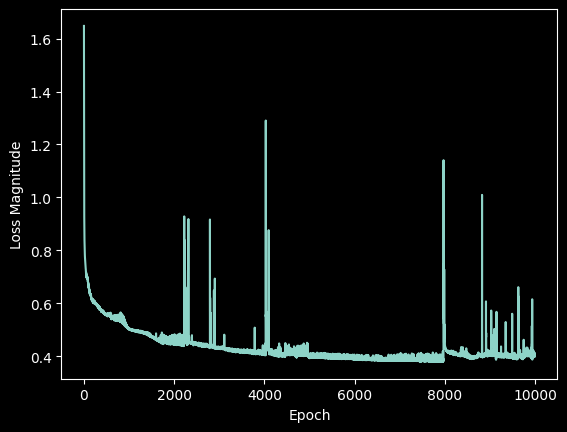

In [14]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss Magnitude')
plt.plot(history)
plt.show()

---

---